<a href="https://colab.research.google.com/github/kmuhan/kmuhandeeplearning/blob/main/masked_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OpenCV를 이용하여 realtime masked detection 기능을 구현 해 보고자 한다.
CNN을 학습하여, openCV에서 활용한다. Reference는 kaggle의 masked face이다.

Structure:

im2col, col2im

epoch: 500, batch_size: 50 eta(학습률): 0.01, wb_width(정규분포): 0.1, data_n: 853, train_data_n: 700, test_data_n: 153, image_crop = center_crop**Optimzation: ADAGRAD**

**VGGNET - VGG19**를 활용하여 이미지를 classification 한다.

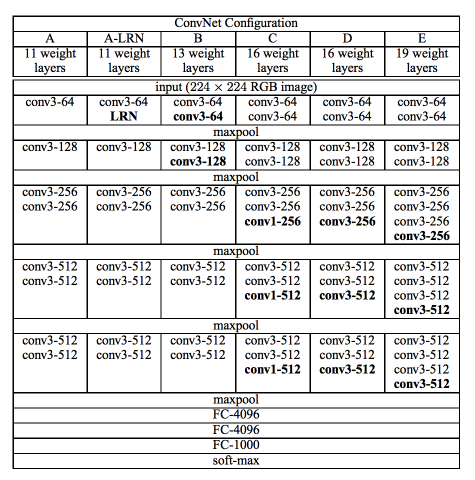

모델은 다음의 형태를 따른다. 이미지를 224, 224로 crop하며, optimization은 크게 개의치 않는다. 

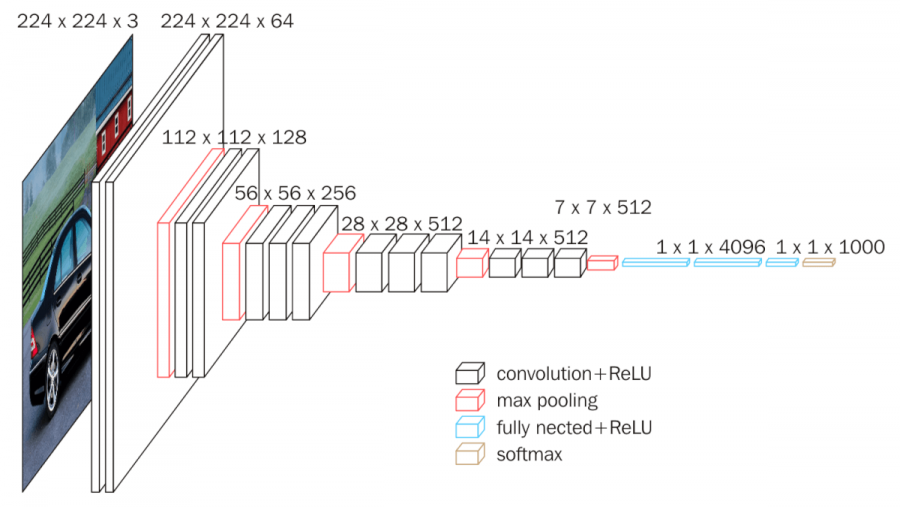

참고한 reference: https://bskyvision.com/504 , "실체가 손에 잡히는 딥러닝" - 아즈마 유키나가


In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml \
    -O haarcascade_frontalface_default.xml

--2021-11-03 16:41:22--  https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.06s   

2021-11-03 16:41:23 (15.0 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import xml.etree.ElementTree as ET
import os

# 마운트 된 구글 드라이브에서 이미지와 xml 파일 read 할 path
image_path = "/content/drive/MyDrive/archive/images_jpg"
xml_path = "/content/drive/MyDrive/archive/annotations"

In [ ]:
def extract_224(image, xml):
  annotation = ET.parse(xml)
  root = annotation.getroot()

  images = []
  corrects = []

  for obj in root.findall('object'):
    # with_mask 인지 without_mask 인지 extract
    is_masked = True if (obj.find('name').text == 'with_mask') else False
    correct = [1, 0] if is_masked == True else [0, 1]

    bndbox = obj.find('bndbox')
    width = int(bndbox.find('xmax').text) - int(bndbox.find('xmin').text)
    height = int(bndbox.find('ymax').text) - int(bndbox.find('ymin').text)
    square_w = width if (width <= height) else height
    
    area = (int(bndbox.find('xmin').text), int(bndbox.find('ymin').text), int(bndbox.find('xmin').text) + square_w, int(bndbox.find('ymin').text) + square_w)
    image_cropped = image.crop(area)
    image_224 = image_cropped.resize((224, 224))

    images.append(image_224)
    corrects.append(correct)

  return images, corrects

In [ ]:

image_array = []
correct_array = []

for img in os.listdir(image_path):
  xml = (xml_path + "/" + img[:-4] + ".xml")
  image = Image.open(image_path + "/" +img)

  image_224, correct = extract_224(image, xml)

  for im in image_224:
    image_array.append(np.array(im))
  for cor in correct:
    correct_array.append(cor)

In [ ]:
print(len(image_array))
image_array = np.array(image_array)
correct_array = np.array(correct_array)
index = np.arange(len(image_array))

index_train = index[index%4 != 0]
index_test = index[index%4 == 0]

input_train = image_array[index_train, :]
correct_train = correct_array[index_train, :]
input_test = image_array[index_test, :]
correct_test = correct_array[index_test, :]

n_train = input_train.shape[0]
n_test = input_test.shape[0]

4072


In [ ]:
img_h = 224  # 입력 이미지 높이
img_w = 224  # 입력 이미지 너비
img_ch = 3  # 입력 이미지 채널 수

wb_width = 0.1  # 가중치와 편향 설정을 위한 정규분포 표준편차
eta = 0.01  # 학습률
epoch = 100
batch_size = 32
interval = 10  # 경과표시 간격
n_sample = 200

In [ ]:
def im2col(images, flt_h, flt_w, out_h, out_w, stride, pad):
   
    n_bt, n_ch, img_h, img_w = images.shape
    
    img_pad = np.pad(images, [(0,0), (0,0), (pad, pad), (pad, pad)], "constant")
    cols = np.zeros((n_bt, n_ch, flt_h, flt_w, out_h, out_w))

    for h in range(flt_h):
        h_lim = h + stride*out_h
        for w in range(flt_w):
            w_lim = w + stride*out_w
            cols[:, :, h, w, :, :] = img_pad[:, :, h:h_lim:stride, w:w_lim:stride]

    cols = cols.transpose(1, 2, 3, 0, 4, 5).reshape(n_ch*flt_h*flt_w, n_bt*out_h*out_w)
    return cols

# -- col2im --
def col2im(cols, img_shape, flt_h, flt_w, out_h, out_w, stride, pad):
 
    n_bt, n_ch, img_h, img_w = img_shape
    
    cols = cols.reshape(n_ch, flt_h, flt_w, n_bt, out_h, out_w).transpose(3, 0, 1, 2, 4, 5)
    images = np.zeros((n_bt, n_ch, img_h+2*pad+stride-1, img_w+2*pad+stride-1))
    
    for h in range(flt_h):
        h_lim = h + stride*out_h
        for w in range(flt_w):
            w_lim = w + stride*out_w
            images[:, :, h:h_lim:stride, w:w_lim:stride] += cols[:, :, h, w, :, :]

    return images[:, :, pad:img_h+pad, pad:img_w+pad]

In [ ]:
# -- 컨볼루션 층--
class ConvLayer:
    
    # n_bt: 배치 사이즈, x_ch:입력 채널 수, x_h:입력 이미지 높이, x_w:입력 이미지 너비
    # n_flt:필터 수, flt_h:필터 높이, flt_w:필터 너비
    # stride:스트라이드 너비, pad:패딩 너비
    # y_ch:출력 채널 수, y_h:출력 높이, y_w:출력 너비
    
    def __init__(self, x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad):

        # 파라미터 정리
        self.params = (x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad)
        
        # 필터와 편향 초기값
        self.w = wb_width * np.random.randn(n_flt, x_ch, flt_h, flt_w)
        self.b = wb_width * np.random.randn(1, n_flt)
        
        # 출력 이미지 크기
        self.y_ch = n_flt  # 출력 채널 수
        self.y_h = (x_h - flt_h + 2*pad) // stride + 1  # 출력 높이
        self.y_w = (x_w - flt_w + 2*pad) // stride + 1  # 출력 너비
 
        # AdaGrad
        self.h_w = np.zeros((n_flt, x_ch, flt_h, flt_w)) + 1e-8
        self.h_b = np.zeros((1, n_flt)) + 1e-8
        
    def forward(self, x):
        n_bt = x.shape[0] 
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 입력이미지와 필터를 행렬로 변환
        self.cols = im2col(x, flt_h, flt_w, y_h, y_w, stride, pad)
        self.w_col = self.w.reshape(n_flt, x_ch*flt_h*flt_w)
        
        # 출력 계산: 행렬곱、편향 더하기, 활성화 함수
        u = np.dot(self.w_col, self.cols).T + self.b
        self.u = u.reshape(n_bt, y_h, y_w, y_ch).transpose(0, 3, 1, 2)
        self.y = np.where(self.u <= 0, 0, self.u)
    
    def backward(self, grad_y):
        n_bt = grad_y.shape[0]
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # delta
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        delta = delta.transpose(0,2,3,1).reshape(n_bt*y_h*y_w, y_ch)
        
        # 필터와 편향 기울기
        grad_w = np.dot(self.cols, delta)
        self.grad_w = grad_w.T.reshape(n_flt, x_ch, flt_h, flt_w)
        self.grad_b = np.sum(delta, axis=0)
        
        # 입력 기울기
        grad_cols = np.dot(delta, self.w_col)
        x_shape = (n_bt, x_ch, x_h, x_w)
        self.grad_x = col2im(grad_cols.T, x_shape, flt_h, flt_w, y_h, y_w, stride, pad)
        
    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b
        

In [ ]:
# -- 풀링층 --
class PoolingLayer:
    
    # n_bt:배차 사이즈, x_ch:입력 채널 수, x_h:입력 이미지 높이, x_w:입력 이미지 너비
    # pool:풀링 영역 크기, pad:패딩 너비
    # y_ch:출력 채널 수, y_h:출력 높이, y_w:출력 너비
    
    def __init__(self, x_ch, x_h, x_w, pool, pad):
        # 파라미터 정리
        self.params = (x_ch, x_h, x_w, pool, pad)

        # 출력 이미지 크기
        self.y_ch = x_ch  # 출력 채널 수
        self.y_h = x_h//pool if x_h%pool==0 else x_h//pool+1  # 출력 높이
        self.y_w = x_w//pool if x_w%pool==0 else x_w//pool+1  # 출력 너비
        
    def forward(self, x):
        n_bt = x.shape[0] 
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 입력 이미지를 행렬로 변환
        cols = im2col(x, pool, pool, y_h, y_w, pool, pad)
        cols = cols.T.reshape(n_bt*y_h*y_w*x_ch, pool*pool)
        
        # 출력 계산: 맥스풀링
        y = np.max(cols, axis=1)
        self.y = y.reshape(n_bt, y_h, y_w, x_ch).transpose(0, 3, 1, 2)
        
        # 최대값 인덱스 저장
        self.max_index = np.argmax(cols, axis=1)
    
    def backward(self, grad_y):
        n_bt = grad_y.shape[0] 
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 출력 기울기의 축 변경
        grad_y = grad_y.transpose(0, 2, 3, 1)
        
        # 행렬을 생성하고、각 열의 최대값이 있던 위치에 출력 기울기 입력
        grad_cols = np.zeros((pool*pool, grad_y.size))
        grad_cols[self.max_index.reshape(-1), np.arange(grad_y.size)] = grad_y.reshape(-1) 
        grad_cols = grad_cols.reshape(pool, pool, n_bt, y_h, y_w, y_ch)
        grad_cols = grad_cols.transpose(5,0,1,2,3,4) 
        grad_cols = grad_cols.reshape( y_ch*pool*pool, n_bt*y_h*y_w)

        # 입력 기울기
        x_shape = (n_bt, x_ch, x_h, x_w)
        self.grad_x = col2im(grad_cols, x_shape, pool, pool, y_h, y_w, pool, pad)

In [ ]:
# -- 전결합층의 부모 클래스 --
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)

        self.h_w = np.zeros(( n_upper, n)) + 1e-8
        self.h_b = np.zeros(n) + 1e-8
        
    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b
        
# -- 전결합 은닉층 --
class MiddleLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)
    
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T) 

# -- 전결합 출력층 --
class OutputLayer(BaseLayer):     
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1).reshape(-1, 1)

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T) 


In [ ]:
#Conv_3_64
conv_3_64_1 = ConvLayer(3, 224, 224, 64, 3, 3, 1, 1)
conv_3_64_2 = ConvLayer(3, 224, 224, 64, 3, 3, 1, 1)

#maxpool
maxpool_1 = PoolingLayer(3, 224, 224, 2, 0)

#Conv_3_128
conv_3_128_1 = ConvLayer(3, 112, 112, 128, 3, 3, 1, 1)
conv_3_128_2 = ConvLayer(3, 112, 112, 128, 3, 3, 1, 1)

#maxpool
maxpool_2 = PoolingLayer(3, 112, 112, 2, 0)

#Conv_3_256
conv_3_256_1 = ConvLayer(3, 56, 56, 256, 3, 3, 1, 1)
conv_3_256_2 = ConvLayer(3, 56, 56, 256, 3, 3, 1, 1)
conv_3_256_3 = ConvLayer(3, 56, 56, 256, 3, 3, 1, 1)

#maxpool
maxpool_3 = PoolingLayer(3, 56, 56, 2, 0)

#Conv_3_512
conv_3_512_1 = ConvLayer(3, 28, 28, 512, 3, 3, 1, 1)
conv_3_512_2 = ConvLayer(3, 28, 28, 512, 3, 3, 1, 1)
conv_3_512_3 = ConvLayer(3, 28, 28, 512, 3, 3, 1, 1)

#maxpool
maxpool_4 = PoolingLayer(3, 28, 28, 2, 0)

#Conv_3_512
conv_3_512_14_1 = ConvLayer(3, 14, 14, 512, 3, 3, 1, 1)
conv_3_512_14_2 = ConvLayer(3, 14, 14, 512, 3, 3, 1, 1)
conv_3_512_14_3 = ConvLayer(3, 14, 14, 512, 3, 3, 1, 1)

#maxpool
maxpool_5 = PoolingLayer(3, 14, 14, 2, 0)

#Fully Connected Layer
n_fc_in_1 = maxpool_5.y_ch * maxpool_5.y_h * maxpool_5.y_w
middle_layer_1 = MiddleLayer(n_fc_in_1, 4096)
middle_layer_2 = MiddleLayer(4096, 4096)
output_layer = OutputLayer(4096, 2)

In [ ]:
def forward_propagation(x):
  n_bt = x.shape[0]

  images = x.reshape(n_bt, 3, 224, 224)
  conv_3_64_1.forward(images)
  conv_3_64_2.forward(conv_3_64_1.y)
  maxpool_1.forward(conv_3_64_2.y)

  conv_3_128_1.forward(maxpool_1.y)
  conv_3_128_2.forward(conv_3_128_1.y)
  maxpool_2.forward(conv_3_128_2.y)

  conv_3_256_1.forward(maxpool_2.y)
  conv_3_256_2.forward(conv_3_256_1.y)
  conv_3_256_3.forward(conv_3_256_2.y)
  maxpool_3.forward(conv_3_256_3.y)

  conv_3_512_1.forward(maxpool_3.y)
  conv_3_512_2.forward(conv_3_512_1.y)
  conv_3_512_3.forward(conv_3_512_2.y)
  maxpool_4.forward(conv_3_512_3.y)

  conv_3_512_14_1.forward(maxpool_4.y)
  conv_3_512_14_2.forward(conv_3_512_14_1.y)
  conv_3_512_14_3.forward(conv_3_512_14_2.y)
  maxpool_5.forward(conv_3_512_14_3.y)

  fc_input = maxpool_5.y.reshape(n_bt, -1)
  middle_layer_1.forward(fc_input)
  middle_layer_2.forward(middle_layer_1.y)
  output_layer.forward(middle_layer_2.y)

def backward_propagation(t):
  n_bt = t.shape[0]

  output_layer.backward(t)
  middle_layer_2.backward(output_layer.grad_x)
  middle_layer_1.forward(middle_layer_2.grad_x)

  grad_img = middle_layer_1.grad_x.reshape(n_bt, maxpool_5.y_ch, maxpool_5.y_h, maxpool_5.y_w)
  maxpool_5.backward(grad_img)
  conv_3_512_14_3.backward(maxpool_5.grad_x)
  conv_3_512_14_2.backward(conv_3_512_14_3.grad_x)
  conv_3_512_14_1.backward(conv_3_512_14_2.grad_x)

  maxpool_4.backward(conv_3_512_14_1.grad_x)
  conv_3_512_3.backward(maxpool_4.grad_x)
  conv_3_512_2.backward(conv_3_512_3.grad_x)
  conv_3_512_1.backward(conv_3_512_2.grad_x)

  maxpool_3.backward(conv_3_512_1.grad_x)
  conv_3_256_3.backward(maxpool_3.grad_x)
  conv_3_256_2.backward(conv_3_256_3.grad_x)
  conv_3_256_1.backward(conv_3_256_2.grad_x)

  maxpool_2.backward(conv_3_256_1.grad_x)
  conv_3_128_2.backward(maxpool_2.grad_x)
  conv_3_128_1.backward(conv_3_128_2.grad_x)

  maxpool_1.backward(conv_3_128_1.grad_x)
  conv_3_64_2.backward(maxpool_1.grad_x)
  conv_3_64_1.backward(conv_3_64_2.grad_x)

def update_wb():
  conv_3_64_1.update(eta)
  conv_3_64_2.update(eta)
  maxpool_1.update(eta)

  conv_3_128_1.update(eta)
  conv_3_128_2.update(eta)
  maxpool_2.update(eta)

  conv_3_256_1.update(eta)
  conv_3_256_2.update(eta)
  conv_3_256_3.update(eta)
  maxpool_3.update(eta)

  conv_3_512_1.update(eta)
  conv_3_512_2.update(eta)
  conv_3_512_3.update(eta)
  maxpool_4.update(eta)

  conv_3_512_14_1.update(eta)
  conv_3_512_14_2.update(eta)
  conv_3_512_14_3.update(eta)
  maxpool_5.update(eta)

  middle_layer_1.update(eta)
  middle_layer_2.update(eta)
  output_layer.update(eta)

# -- 오차 계산 --
def get_error(t, batch_size):
    return -np.sum(t * np.log(ol_1.y + 1e-7)) / batch_size

In [ ]:
# -- 샘플을 순전파 --
def forward_sample(input, correct, n_sample):
    index_rand = np.arange(len(correct))
    np.random.shuffle(index_rand) 
    index_rand = index_rand[:n_sample]
    x = input[index_rand, :]
    t = correct[index_rand, :]
    forward_propagation(x)
    return x, t


train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

#학습 및 오차 기록
n_batch = n_train // batch_size
for i in range(epoch):

  #오차 측정
  x, t = forward_sample(input_train, correct_train, n_sample)
  error_train = get_error(t, n_sample)

  x, t = forward_sample(input_test, correct_test, n_sample) 
  error_test = get_error(t, n_sample)

  # -- 오차 기록 -- 
  train_error_x.append(i)
  train_error_y.append(error_train) 
  test_error_x.append(i)
  test_error_y.append(error_test) 

  # -- 경과 표시 --
  if i%interval == 0:
    print("Epoch:" + str(i) + "/" + str(epoch),
          "Error_train:" + str(error_train),
          "Error_test:" + str(error_test))
    
  index_rand = np.arange(n_train)
  np.random.shuffle(index_rand)
  for j in range(n_batch):
    mb_index = index_rand[j*batch_size : (j+1)*batch_size]
    x = input_train[mb_index, :]
    t = correct_train[mb_index, :]

    forward_propagation(x)
    backward_propagation(t)
    update_wb()

In [ ]:
# -- 오차의 기록을 그래프로 표시 -- 
plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

# -- 정답률 측정 -- 
x, t = forward_sample(input_train, correct_train, n_train) 
count_train = np.sum(np.argmax(ol_1.y, axis=1) == np.argmax(t, axis=1))

x, t = forward_sample(input_test, correct_test, n_test) 
count_test = np.sum(np.argmax(ol_1.y, axis=1) == np.argmax(t, axis=1))

print("Accuracy Train:", str(count_train/n_train*100) + "%",
      "Accuracy Test:", str(count_test/n_test*100) + "%")